# サービスネットワーク設計システム SENDO 

> サービスネットワーク設計 SENDO (SErvice Network Design Optimizer) 



In [ ]:
#| default_exp snd

In [ ]:
#| include: false
from nbdev.showdoc import *
%reload_ext autoreload
%autoreload 2 

In [ ]:
#| export
import pandas as pd
import random
import math
import numpy as np
import networkx as nx
from geopy.distance import great_circle as distance

import sys
sys.path.append('..')
from pulp import PULP_CBC_CMD
from scmopt2.mypulp import  GRB, quicksum, Model

#from gurobipy import Model, GRB, quicksum
import plotly.graph_objs as go
import plotly.express as px
import plotly
from collections import OrderedDict, defaultdict
folder = "./data/"

mapbox_access_token = 'pk.eyJ1IjoibWlraW9rdWJvIiwiYSI6ImNqYXQ3dHBqdzR5ZGwyd3BkeG5rOTl0b2UifQ.1utsXNi2V-WdzfWlvCMj_A'

## 簡易システムの紹介ビデオ

サービスネットワーク設計最適化システム　SENDO

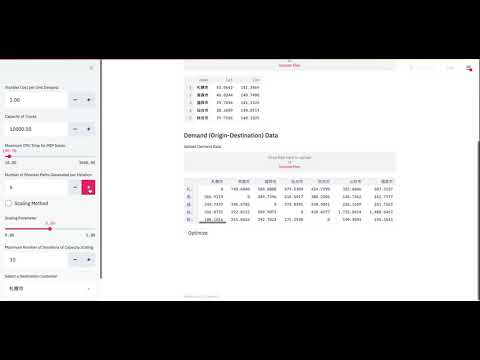

In [ ]:
#| echo: false
from IPython.display import Image, YouTubeVideo
YouTubeVideo("GY0L8frFNko")

## はじめに

ロジスティクス・ネットワークが供給地点から需要地点への，一方向的な「もの」の流れを扱うのに対して，
サービス・ネットワークでは，発地と着地の間に輸送される，多対多の「もの」の流れを扱う．
ロジスティクス・ネットワークにおいては，顧客需要の不確実性やサービス・レベルの要求などの条件を満たすために，
ネットワーク内の地点で在庫を適切に管理することが重要になる．
それに対して，サービス・ネットワークにおいては，基本的には途中で在庫することなく，
発地から着地へ「もの」が流れていく．
（ただし，輸送のタイミングをとるために，一時保管することは許される．）

**サービス・ネットワーク設計問題**（consolidation transportation network design problem）は，
しばしば混載ネットワーク設計問題ともよばれる．
しかし，我が国における実務家の間では，「混載」という用語が「異なる種類の製品の積み合わせ」という意味で用いられ，本モデルでは，同じ種類の製品の積み合わせが主な応用であるため，
混乱を避ける意味でサービス・ネットワーク設計問題とよぶことにする．
ここで考えるモデルでは，
主に（郵便物や宅配便のように）発地・着地が異なる同じ種類の製品の積み合わせを対象とする
場合が多いが，異なる種類の製品の積み合わせ（いわゆる業界用語での混載）への適用も可能である．

配送計画は，比較的短距離の輸送を計画するためのモデルであるが，
サービス・ネットワーク設計では比較的長距離の輸送を対象とする．
そのため，途中での積み替えを考慮する必要が出てくる．
これが，ここで考えるサービス・ネットワーク設計が，
配送計画と異なったアプローチを必要とする理由である．
配送計画においては，積み替えを考慮する必要がなかったので，運搬車の移動経路を求めれば，
荷（品目）の移動は自動的に定まった．一方，サービス・ネットワーク設計においては，
積み替えを考慮する必要があるので，運搬車の流れのみならず，荷の流れが意思決定項目となり，
これによって問題の難しさが増大する．

ここで考えるモデルは，実務から生まれたものであり，以下の仮定に基づく．

- **荷**（load）とは，地点間を移動させる「モノ」の総称である．ネットワーク理論では**品種**(commodity) とよばれるが，ここでは現実問題を想定していることを強調するために荷とよぶことにする．
荷は，その移動によって利益を生む資源の総称である． 荷が最初に出発する（最後に到着する）地点を荷の発地（着地）とよび，あらかじめ決められている．
ネットワーク理論では，**発地**（source）は始点もしくは発生点，**着地**（sink, terminal）は終点もしくは集中点とよばれるが，以下では，発地，着地とよぶものとする．

- 荷は途中で分岐してはならない．言い換えれば，荷の発地から着地までの移動経路は，1本のパスでなければならない．

- 宅配便や郵便事業などへの応用では，さらに荷の移動に入木条件とよばれる制約が付加される． 入木条件とは，着地が同じ荷のパスが合流したら，その後のパスは同じ経路にならなければならないことを規定する．
これは，集荷した荷物を積み替え（ソーティング）する際に，現場でのオペレーションの簡便性のため，
着地の情報だけを利用するためである．
実際に，東京行きの荷物という荷の集まりは，様々な発地からの荷が集約されたものであり，これを発地別に分けて
異なる方面行きの運搬車に積み替えることは
（たとえそれによって費用が減少する可能性があっても）現実には行われないのである．

- 運搬車（トラック）の積載容量は既知であり，積載される荷量の合計は積載容量を超えない．

- 地点間の運搬車の移動費用は既知である．

- 中継地点での積替え費用は荷量によって定まり，既知である．

- 運搬車は出発地点に戻ってくる必要はない．（この仮定を緩めるのは比較的容易である．）

上のサービス・ネットワーク設計モデルに対して，数理最適化（ならびに制約最適化）ソルバーを利用した専用解法を構築する．

#hide
## モデルの定式化
サービスネットワーク設計問題の定式化を示す.
ターミナル間の需要量の予測値をもとに，各ターミナルに対して，他のターミナル行きの荷物を，どのターミナルに輸送すれば良いのかを指示する．
以下に,定式化を行うために必要な記号と集合を説明した後に,定式化を示す.


集合:

- $G=(N,A)$: 有向グラフ:；点集合はターミナルの集合，枝集合は移動可能な点対の集合． 

- $K$: 発ターミナル・着ターミナルの組（これを品種と呼ぶ）の集合． 

- $P_k$: 品種 $k \in K$ に対するパスの集合． すべてのパスの集合を $P$ とする．

- $A_{pk}$:  品種 $k$ に対するパス $p$ （これをパス $p,k$ と呼ぶ）が使用する枝の集合．


パラメータ: 

- $o_k, d_k$: 品種 $k$ の発ターミナルと着ターミナル 
- $D_{k}$: 品種 $k$ の需要量（発ターミナルから着ターミナルまでの荷量)
- $c_{ij}$: 枝 $(i,j)$ の固定費用（トラック1台あたりの移動費用）． 簡単のため最も多い10トントラックのみと仮定する．

- $C_{pk}$: 品種 $k$ に対するパス $p$ の変動費用（需要量 $1$ 単位あたりの費用）
- $M_{ij}$: トラック1台あたりの容量
- $Succ_{pk}$:  品種 $k$ に対するパス $p$ の最初の枝を除去したパス（後続パス）


変数:

- $x_{pk}$: 品種 $k$ に対してパス $p$ が使われるとき $1$，それ以外のとき $0$
- $y_{ij}$: 枝 $(i,j)$ 上を移動するトラックの台数（整数変数）


定式化:

$$
\begin{array}{l l l } 
minimize  &  \sum_{(i,j) \in A} c_{ij}  y_{ij} + \sum_{k \in K} \sum_{p \in P_k} C_{pk} D_{k} x_{pk} &  \\
s.t.      & \sum_{p \in P_k} x_{pk} = 1   &  \forall k \in K  \\
          & \sum_{p,k:(i,j) \in A_{pk}} D_{k} x_{pk} \leq M_{ij} y_{ij} & \forall (i,j) \in A\\
          & x_{pk} \leq x_{p',k'}             &     \forall (p',k') = Succ_{pk}\\
   &\lceil D_k/M_{ij} \rceil x_{pk} \leq y_{ij}  & \forall (i,j) \in A_{pk}, p \in P_k, k \in K\\
     & \sum_{(i,j) \in (S,N \setminus S)} y_{ij} \geq 
\lceil \sum_{k: o_k \in S, d_k \in N \setminus S } D_k/M \rceil &  \forall S \subset N, S \neq \emptyset
\end{array}
$$

制約の意味は以下の通り。

1. パス選択制約：各品種はいずれかのパスによって流さなければならない.

2. 容量制約: 各枝上を流れる品種の量の合計は，その枝上を移動したトラックの容量の合計を超えてはいけない．

3. 入木制約: パス $p,k$ $=(n_1,n_2,\ldots, n_m)$ が選ばれたときには，その後続パス $p', k'$ $=(n_2,\ldots, n_m)$も選択されなければならない． つまり、同じ着地をもつ品種が一度合流したら，同じパス上を移動しなければならない．

4. 強化制約： 品種 $k \in K$ に対するパスの集合は，ちょうど1つ選択する必要があるが，それらのパスが通過する枝 $(i,j)$ に対して需要 $D_k$ を満たす分のトラックが移動しなければならない．

5. カットセット制約： 点の部分集合 $S$ とそれ以外の点集合 $N \setminus S$ へ移動する需要量を満たすだけのトラックが，$S$ から $N \setminus S$ へ移動しなければならない．これは，すべてのトラック容量 $M_{ij}$ が同一量 $M$ であるときに使われ，カットセット制約とよばれる．


適切なパスを生成するための勾配スケーリング法

ある枝 $(i,j)$ に対して説明するので，以下の記号では添字の $ij$ を省略する．

$y$ は整数変数であるが，緩和して求解する．その解を $\bar{y}$ とする．
本来の費用は $c \lceil \bar{y} \rceil$ であるので， $\bar{y}$ のときに　$c \lceil \bar{y} \rceil$ になるように勾配を調整する．
新しい勾配は， $c \lceil \bar{y} \rceil/\bar{y}$ となる． 

実際には，現在の費用 $c'$ と新しい勾配をパラメータ $0 < \alpha < 1$ で調整し．
$$
c' := \alpha c \lceil \bar{y} \rceil/\bar{y} + (1-\alpha) c' 
$$
と設定する． $\alpha$ が $0$ に近いほどほどあまり解を変えないように勾配を調整し， $1$ に近いほど大胆に勾配を調整するようになる． 


#hide
## 階層的アプローチ

- サービスネットワーク設計 (SND): OD間のパスを求める．
- 時空間ネットワーク上でのフロー最適化： 運搬車の中継地点とスケジュールを求める．
- 積み込み・積み下ろし型配送計画： 運搬車の移動経路を求める．



## データの読み込み

- dc_df : 倉庫（拠点）データフレーム
- od_df : OD需要データフレーム

In [ ]:
od_df = pd.read_csv(folder +"od.csv", index_col=0)
Demand = od_df.values
#Demand
dc_df = pd.read_csv(folder+"DC.csv", index_col=0)
n = len(dc_df)
dc_df.head()

,name,lb,ub,fc,vc,lat,lon
0,札幌市,0.0,501136.2,10037,0.432510,43.06417,141.34694
1,青森市,0.0,501136.2,10235,0.414573,40.82444,140.74000
2,盛岡市,0.0,501136.2,10908,0.414802,39.70361,141.15250
3,仙台市,0.0,501136.2,10072,0.136525,38.26889,140.87194
4,秋田市,0.0,501136.2,10767,0.029622,39.71861,140.10250


In [ ]:
# OD需要のヒストグラムの描画
trace1 = go.Histogram(
    x= [ Demand[i,j] for i in range(n) for j in range(n) ], 
    opacity=0.5,
    name="OD間需要"
)

data = [trace1]
layout = go.Layout(
    title='OD間需要量',
    xaxis=dict(
        title="需要量"
    ),
    yaxis=dict(
        title='件数'
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.plot(fig);

## 第k最短路を解くための関数

引数：

- G : NetworkXのグラフ
- source : 始点
- sink : 終点
- k : 第k最短路（単純パス）を求める。
- weight : 移動距離を評価するための枝の属性名

返値：

- cost_list : k本のパスの費用を入れたリスト
- path_list : k本のパス（点列のタプル）を入れたリスト


In [ ]:
#| export
def k_th_sp(G, source, sink, k, weight="weight"):
    """
    Find k-th shortest paths and returns path and its cost
    """
    cost_list, path_list = [], []
    for i, p in enumerate(nx.shortest_simple_paths(G, source, sink, weight=weight)):
        if i >= k:
            break
        v = p[0]
        cost = 0.
        for w in p[1:]:
            cost += G[v][w]["weight"]
            v = w
        cost_list.append( cost )
        path_list.append( tuple(p))
    return cost_list, path_list

#hide
## サービスネットワーク設計モデル sndp

サービスネットワーク設計問題に対するパス型のモデル

引数：

- K : 発生点と到着点の対を入れたリスト
- all_paths = set of all paths
- paths[o,d] = set of all paths from o to d
- path_od[p] = dictionary that maps a path (tuple) to its origin-destination pair (tuple)
- path_id[p] = dictionary that maps a path to its ID
- paths_through[v,w] = set of paths through edge (v,w) 

返値：

- model: 最適化された後のモデルファイル．model.__data に解（x,y,total_transfer_cost, total_vehicle_cost)が保管されている．
最適化の状態は， model.Statusで確認できる．Statusの値はGurobiに準じており，以下の通り．

- OPTIMAL = 1
- INFEASIBLE = 3
- INF_OR_UNBD = 4
- UNBOUNDED = 5
- UNDEFINED = None
        

In [ ]:
#| export
def sndp(K, all_paths, paths, path_id, path_od, paths_through, Demand, Distance,
         transfer_cost, capacity, relax = False, cpu=10.):
    """
    サービスネットワーク設計問題に対するパス型のモデル
    """
    m = Model()
    x, y = {}, {}
    for (i,j) in K:
        if relax:
            y[i,j]= m.addVar(name="y[{0},{1}]".format(i,j), vtype="C")
        else:
            y[i,j]= m.addVar(name="y[{0},{1}]".format(i,j), vtype="I") #トラックの台数
    for p, i in path_id.items():
        x[i]= m.addVar(name="x[{0}]".format(i),vtype="B")
    total_transfer_cost = m.addVar(name="total_transfer_cost", vtype="C")
    total_vehicle_cost =  m.addVar(name="total_vehicle_cost", vtype="C")
        
    m.update()
    #パスごとの積替え費用の準備
    trans_cost ={} 
    for (o,d) in K:
        for p in paths[o,d]:
            sum_tc = 0.
            for i in  p:   #p[1:-1]: 最初と最後の積替えを除く場合
                sum_tc += transfer_cost[i]
            trans_cost[p] = sum_tc
            
    #目的関数
    m.setObjective( total_transfer_cost+ total_vehicle_cost, GRB.MINIMIZE )
    m.addConstr( total_transfer_cost == quicksum(Demand[o,d]* trans_cost[p] * x[ path_id[p] ] for (o,d) in K for p in paths[o,d] ) ) 
    m.addConstr( total_vehicle_cost == quicksum(Distance[i,j]*y[i,j] for (i,j) in y ) )
        
    for (o,d) in K:
        m.addConstr( quicksum( x[ path_id[p] ] for p in paths[o,d] ) == 1 )
    for (i,j) in K:
        m.addConstr( quicksum(Demand[path_od[p][0],path_od[p][1]] * x[path_id[p]] for p in paths_through[i,j])  <= capacity*y[i,j] )
    # 後続パスを用いた入木制約
    intree_const = {}
    for p in all_paths:
        if len(p)>=3:
            intree_const[path_id[p], path_id[p[1:] ]] = m.addConstr( x[path_id[p]]  <= x[path_id[p[1:]]] )
            #intree_const[path_id[p], path_id[p[1:] ]].Lazy = 3
    #Gurobiの場合
    #m.Params.Heuristics = 0.8
    #m.Params.OutputFlag = 0
    #m.Params.TIME_LIMIT = cpu
    #m.optimize()

    # mypulpの場合
    solver = PULP_CBC_CMD(timeLimit=cpu, presolve=True)
    m.optimize(solver)
    #print("obj fun. val. =", m.ObjVal)
    m.__data = x, y, total_transfer_cost, total_vehicle_cost 
    return m

In [ ]:
#| export
def  add_shortest_paths(G, K, all_paths, paths, path_id, path_od, paths_through, k=1):
    """
    各地点間の第k最短路を計算し、追加する関数
    """
    def add_path(p,o,d):
        """
        入木制約を満たすために後続のパスを再帰的に追加する関数
        """
        if len(p)<=2 or p in paths[o,d]:
            return
        paths[o, d].add(p)
        path_od[p] =(o,d)
        all_paths.add(p)
        path_id[p] = len(all_paths)
        v = p[0]
        for w in p[1:]:
            paths_through[(v,w)].add(p)
            v = w
        add_path(p[1:],p[1],d)

    for (o, d) in K:
        cost, path = k_th_sp(G, o, d, k)
        for p in path:
            add_path(p,o,d)

### 結果のデータフレーム生成関数 make_result

In [ ]:
#| export
def make_result(Demand, cust_df, K, paths, path_id, path_od, paths_through, x, y):
    n = len(cust_df)
    cust_name = cust_df.name.values
    origin, destin, od_path = [],[],[]
    for o in range(n):
        for d in range(n):
            if d==o:
                continue
            origin.append(cust_name[o])
            destin.append(cust_name[d])

            for p in paths[o,d]:
                 if x[path_id[p]].X > 0.1:
                    path_list = []
                    for v in p:
                        path_list.append( cust_name[v] )
            od_path.append( path_list )
    path_df = pd.DataFrame({"origin":origin, "destination":destin, "path":od_path})
    
    head, tail, flow, number = [],[],[],[]
    head_id, tail_id = [], []
    for (v,w) in K:
        if y[v,w].X > 0.1:
            head_id.append(v)
            tail_id.append(w)
            head.append( cust_name[v] )
            tail.append( cust_name[w] )
            number.append( y[v,w].X )
            flow.append( sum(Demand[path_od[p][0],path_od[p][1]] * x[path_id[p]].X for p in paths_through[v,w]) )
            
    vehicle_df = pd.DataFrame({"from_id": head_id, "to_id": tail_id, "from":head, "to":tail, "flow": flow, "number": number})

    return path_df, vehicle_df

### サービスネットワーク設計問題の可視化関数 draw_snd_all

In [ ]:
#| export
def draw_snd_all(dc_df, x, y, pos, paths, path_id):
    """
    可視化関数
    """

    n = len(dc_df)
    K = [(i,j) for i in range(n) for j in range(n) if i!=j]

    #ベースの描画
    data = [
        go.Scattermapbox(
            lat=dc_df.lat,
            lon=dc_df.lon,
            mode='markers',
            marker=dict(
                size=20, color="blue", opacity=0.9
            ),
            text=dc_df.name,
            name="DCs"
        ),
    ]

    #運搬車の台数の描画
    edge_trace_lat, edge_trace_lon = [], []
    for (v,w) in K:
        if y[v,w].X > 0.1:
            edge_trace_lat += [pos[v][1], pos[w][1], None]
            edge_trace_lon += [pos[v][0], pos[w][0], None]
    data.append(
            go.Scattermapbox(
                lat=edge_trace_lat,
                lon=edge_trace_lon,
                line=dict(width=5, color="yellow"),
                hoverinfo='none',
                mode='lines',
                name= "Vehicle Movement"
            )
        )
    for d in range(n):
        destination = dc_df.name[d]
        #着地がdのパスの枝を抽出
        edge_trace_lat, edge_trace_lon = [], []
        G_sol = nx.Graph()
        for o in range(n):
            if d==o:
                continue
            for p in paths[o,d]:
                if x[path_id[p]].X > 0.1:
                    v = p[0]
                    for w in p[1:]:
                        G_sol.add_edge(v,w)
                        v = w
        for (v,w) in G_sol.edges():
            edge_trace_lat += [pos[v][1], pos[w][1], None]
            edge_trace_lon += [pos[v][0], pos[w][0], None]

        data.append(
                go.Scattermapbox(
                    lat=edge_trace_lat,
                    lon=edge_trace_lon,
                    line=dict(width=2,color="red"),
                    hoverinfo='none',
                    mode='lines',
                    name= "Paths to "+ str(destination)
                )
            )

    layout = go.Layout(
        autosize=True,
        hovermode='closest',
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=dict(
                lat=35.8573157,
                lon=139.64696
            ),
            pitch=0,
            zoom=5,
            style="dark"  # 'satellite-streets'
        ),
    )
    fig = go.Figure(data=data, layout=layout)
    return fig

## サービスネットワーク設計問題を解くための関数 solve_sndp

引数：
- dc_df: 倉庫データフレーム（緯度・経度情報，容量，変動費用（積替え費用）を利用）
- od_df: 発地・着地間の需要量を保管したデータフレーム
- cost_per_dis: 1kmあたりの運搬車の変動費用（人件費を含まず）
- cost_per_time: 1時間あたりの運搬車の変動費用
- capacity: 運搬車の積載容量
- max_cpu: 最大CPU時間
- scaling: 勾配スケーリング法を用いるとき True 
- k: 最短路の本数
- alpha: 勾配スケーリング法のパラメータ
- max_iter: 勾配スケーリング法の最大反復回数
- osrm: 地図　（OSRM) を利用するとき True

返値：
- path_df: 解のパス情報を保管したデータフレーム
- vehicle_df: 解の運搬車情報を保管したデータフレーム
- cost_df: 費用の内訳を表すデータフレーム
- fig: 図オブジェクト

In [ ]:
#| export
def solve_sndp(dc_df, od_df, cost_per_dis, cost_per_time, capacity, max_cpu = 10, scaling=True, k=10, alpha=0.5, max_iter = 100, osrm = False):
    """
    サービスネットワーク設計問題を解くための関数
    """    
    n = len(dc_df)
    Demand = od_df.values
    
    transfer_cost = dc_df.vc #積替え費用
    base_capacity = dc_df.ub #ベースの容量（現在は未使用）
    
    #実距離と移動時間
    if osrm:
        durations, distances, node_df = compute_durations(dc_df)
        distances = np.array( distances )/1000.  # m => km 
        durations = np.array( durations )/3600.  # seconds => h
    else:
        distances = np.zeros( (n,n) )
        durations = np.zeros( (n,n) )
        for i, row1 in enumerate(dc_df.itertuples()):
            for j, row2 in enumerate(dc_df.itertuples()):
                distances[i,j] = distance( (row1.lat, row1.lon), (row2.lat,row2.lon) ).km
                durations[i,j] = distances[i,j]/50 #時速50kmを仮定
    
    K = [(i,j) for i in range(n) for j in range(n) if i!=j]
    
    cost = np.zeros ( (n,n) )
    for (i,j) in K:
        cost[i,j] = (distances[i,j]*cost_per_dis + durations[i,j]*cost_per_time) 
                
    G  = nx.DiGraph() #元のグラフ（距離を枝属性として保管）
    pos = { }
    for i, row in enumerate(dc_df.itertuples()):
        G.add_node(i, lat=row.lat, lon=row.lon)
        pos[i] = (G.nodes[i]["lon"],G.nodes[i]["lat"])
    for (i,j) in K:
        G.add_edge(i, j, weight = cost[i,j])

    all_paths = []
    paths = {}
    #path_cost = {}
    path_od ={} #dictionary that maps a path (tuple) to its origin-destination pair (tuple)
    for (o, d) in K:
        cost_, path = k_th_sp(G, o, d, k)
        paths[o, d] = set(path)
        for p in path:
            path_od[p] =(o,d)
        #path_cost[o, d] = cost
        all_paths.extend(path)
    # Dictionary that maps a path (tuple) to the path index
    path_id ={}
    for i, p in enumerate(all_paths):
        path_id[p] = i

    # set of paths through edge (v,w)
    paths_through = defaultdict(set)
    for p in path_id:
        v = p[0]
        for w in p[1:]:
            paths_through[(v,w)].add(p)
            v = w
    #paths_through
    all_paths = set(all_paths) #集合に変換

    #print("# of paths", len(all_paths))

    #勾配スケーリング＋列生成
    CPrime = cost.copy() 
    if scaling:
        for iter_ in range(max_iter):
            model = sndp(K, all_paths, paths, path_id, path_od, paths_through, Demand, CPrime, transfer_cost, capacity, relax = True, cpu=max_cpu)
            if model.Status !=2:  #実行不能 or エラー
                raise SolverError(f"Falied to solve the problem! Status Code is {model.Status}.")
            x,y,_,_ = model.__data
            for (i,j) in K:
                ybar = y[i,j].X
                if ybar>=0.000001:
                    ratio = math.ceil(ybar)/ybar
                    CPrime[i,j] = alpha* cost[i,j]*ratio + (1-alpha) * CPrime[i,j]
                    G[i][j]["weight"] = CPrime[i,j]
                    #print( Cost[i,j], distances[i,j]*ratio, ybar)

            before_ = len(all_paths)
            add_shortest_paths(G, K, all_paths, paths, path_id, path_od, paths_through, k=k)

            #print("# of paths", len(all_paths))
            after_ = len(all_paths)
            if before_ == after_:
                break

    # オリジナルの費用で整数最適化を解く
    model = sndp(K, all_paths, paths, path_id, path_od, paths_through, Demand, cost, transfer_cost, capacity, relax = False, cpu=max_cpu)
    if model.Status != 2:  #実行不能 or エラー
        raise SolverError(f"Falied to solve the problem! Status Code is {model.Status}.")

    x, y, total_transfer_cost, total_vehicle_cost  = model.__data
        
    #結果のデータフレーム作成
    cost_list =[total_transfer_cost.X, total_vehicle_cost.X ]
    cost_name =["transfer", "vehicle"]
    cost_df = pd.DataFrame.from_dict({"cost": cost_name, "value":cost_list})
    
    path_df, vehicle_df = make_result(Demand, dc_df, K, paths, path_id, path_od, paths_through, x, y)
    
    #図作成
    fig = draw_snd_all(dc_df, x, y, pos, paths, path_id)

    return path_df, vehicle_df, cost_df, fig

### solve_sndp関数の使用例

In [ ]:
dc_df = pd.read_csv(folder + "DC.csv", index_col=0) #ub =base capacity, vc = transfer cost
od_df = pd.read_csv(folder + "od.csv", index_col=0)

# 問題のサイズの縮小
n= 10
dc_df = dc_df.iloc[:n,:]
od_df = od_df.iloc[:n,:n]

try:
# just MIP
    #path_df, vehicle_df, cost_df, fig = solve_sndp(dc_df, od_df, cost_per_dis=20, cost_per_time=8000, capacity=1000., max_cpu = 10, scaling=False, k=10, alpha=0.9, max_iter = 10, osrm = False)
# slope scaling + column generation
    path_df, vehicle_df, cost_df, fig = solve_sndp(dc_df, od_df, cost_per_dis=20, cost_per_time=8000, capacity=1000., max_cpu = 10, scaling=True, k=10, alpha=0.5, max_iter = 10, osrm = False)
except SolverError as e:
    print(e)

In [ ]:
Demand = od_df.values
od_df

,札幌市,青森市,盛岡市,仙台市,秋田市,山形市,福島市,水戸市,宇都宮市,前橋市
name,,,,,,,,,,
札幌市,0.000000,748.604013,503.880787,479.530853,434.728978,325.400616,387.515654,380.707553,320.950984,306.975814
青森市,366.911870,0.000000,349.739599,216.591680,300.250555,146.736232,161.797705,137.690614,117.949336,110.061161
盛岡市,244.733739,346.578201,0.000000,374.849054,440.904081,236.165870,241.756337,178.105294,151.641357,135.078213
仙台市,316.873079,292.012168,509.987066,0.000000,420.427689,1732.062426,1488.646715,574.094165,492.841131,390.859150
秋田市,188.101580,265.062360,392.782315,275.293764,0.000000,199.309319,195.354280,142.173921,125.495887,115.713660
山形市,148.099418,136.258227,221.302373,1192.970578,209.647039,0.000000,864.339836,280.457384,255.262338,206.987265
福島市,230.485306,196.343595,296.050510,1339.913763,268.536343,1129.545011,0.000000,646.117267,588.446899,425.126180
水戸市,280.695094,207.127638,270.367267,640.556839,242.264298,454.333986,800.941289,0.000000,2276.291965,1030.798300
宇都宮市,194.660712,145.957188,189.361294,452.353290,175.911907,340.166357,600.057519,1872.510381,0.000000,1138.705559


In [ ]:
vehicle_df.head()

,from_id,to_id,from,to,flow,number
0,0,1,札幌市,青森市,2721.081032,3.0
1,0,3,札幌市,仙台市,1167.214220,2.0
2,1,0,青森市,札幌市,2156.888050,3.0
3,1,2,青森市,盛岡市,991.311000,1.0
4,1,4,青森市,秋田市,1061.632374,2.0


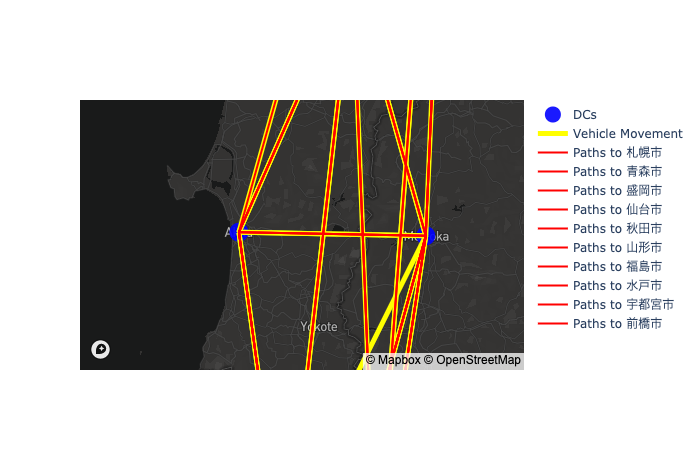

In [ ]:
#| echo: false
#plotly.offline.plot(fig);
Image("../figure/show_snd_all.png")

In [ ]:
cost_df

,cost,value
0,transfer,95017.015
1,vehicle,2161830.800


#hide
### サービスネットワーク設計問題の可視化関数 draw_snd

着地点が destination の場合の描画

In [ ]:
#| include: false
def draw_snd(cust_df, x, y, pos, paths, path_id, destination):
    """
    可視化関数
    """

    n = len(cust_df)
    K = [(i,j) for i in range(n) for j in range(n) if i!=j]

    try:
        cust_df.set_index("name", inplace=True)
    except:
        pass
    d = cust_df.index.get_loc(destination)
    cust_df.reset_index(inplace=True)
    data = [
        go.Scattermapbox(
            lat=cust_df.lat,
            lon=cust_df.lon,
            mode='markers',
            marker=dict(
                size=10, color="blue", opacity=0.9
            ),
            text=cust_df.name,
            name="Customers"
        ),
    ]

    edge_trace_lat, edge_trace_lon = [], []
    for (v,w) in K:
        if y[v,w] > 0.1:
            edge_trace_lat += [pos[v][1], pos[w][1], None]
            edge_trace_lon += [pos[v][0], pos[w][0], None]
    data.append(
            go.Scattermapbox(
                lat=edge_trace_lat,
                lon=edge_trace_lon,
                line=dict(width=0.1, color="yellow"),
                hoverinfo='none',
                mode='lines',
                name= "Used Edges"
            )
        )

    edge_trace_lat, edge_trace_lon = [], []
    G_sol = nx.Graph()
    for o in range(n):
        if d==o:
            continue
        for p in paths[o,d]:
            if x[path_id[p]] > 0.1:
                v = p[0]
                for w in p[1:]:
                    G_sol.add_edge(v,w)
                    v = w
    for (v,w) in G_sol.edges():
        edge_trace_lat += [pos[v][1], pos[w][1], None]
        edge_trace_lon += [pos[v][0], pos[w][0], None]

    data.append(
            go.Scattermapbox(
                lat=edge_trace_lat,
                lon=edge_trace_lon,
                line=dict(width=0.8,color="red"),
                hoverinfo='none',
                mode='lines',
                name= "Paths to "+ str(destination)
            )
        )

    layout = go.Layout(
        autosize=True,
        hovermode='closest',
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=dict(
                lat=35.8573157,
                lon=139.64696
            ),
            pitch=0,
            zoom=5,
            style="dark"  # 'satellite-streets'
        ),
    )
    fig = go.Figure(data=data, layout=layout)
    return fig

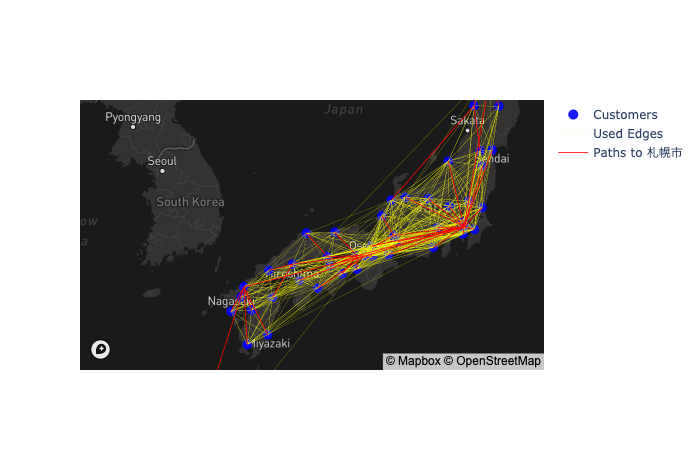

In [ ]:
#| echo: false
#fig = draw_snd(dc_df, x, y, pos, paths, path_id, destination="札幌市")
#plotly.offline.plot(fig);
Image("../figure/draw_snd.png")

In [ ]:
#| include: false
# #強化制約（パス変数とトラック台数変数との関係式）
# force ={}
# for (b1,b2) in K:
#     #print("Variablle: now processing",b1.name,b2.name)
#     for (count,o,d) in ODpath[b1.name,b2.name]:
#         edges = edgeInPath[count, o, d ] 
#         if len(edges)<=1:
#             for (i,j) in edges:
#                 force[count,o,d,i,j] = m.addConstr( (int( (demand_dic[o,d]-0.0001)/800 ) +1 ) *x[count,o,d] <=  y[i,j] )
#                 force[count,o,d,i,j].Lazy = 3
                
# # 点ごとのカットセット制約（強化用）
# # 出る量に対する制約
# cutset1 ={} 
# for b1 in B0:
#     total_demand = 0.
#     for b2 in B0:
#         if b1 != b2:
#             total_demand += demand_dic[b1.name,b2.name]
#     cutset1[b1.name] = m.addConstr( (int( (total_demand -0.0001)/800 ) +1 )  <=  gurobi.quicksum( y[i,j] for (i,j) in y if i==b1.name ) )
#     #cutset1[b1.name].Lazy = 3 
# # 入ってくる量に対する制約
# cutset2 ={} 
# for b1 in B0:
#     total_demand = 0.
#     for b2 in B0:
#         if b1 != b2:
#             total_demand += demand_dic[b2.name,b1.name]
#     cutset2[b1.name] = m.addConstr( (int( (total_demand -0.0001)/800 ) +1 )  <=  gurobi.quicksum( y[j,i] for (j,i) in y if i==b1.name ) )
#     #cutset2[b1.name].Lazy = 3             
# #m.Params.Method = 2 # barrier method
# m.Params.Heuristics = 0.8
# m.Params.TIME_LIMIT = 3600.0*2
# m.optimize()
# print("obj fun. val. =", m.ObjVal)
# #for (i,o,d) in x:
# #    if x[i,o,d].X > 0:
# #        print(i,o,d,x[i,o,d].X)
# #for (i,j) in y:
# #    if y[i,j].X >0:
# #        print(i,j,y[i,j].X)

#hide
### AGV への応用

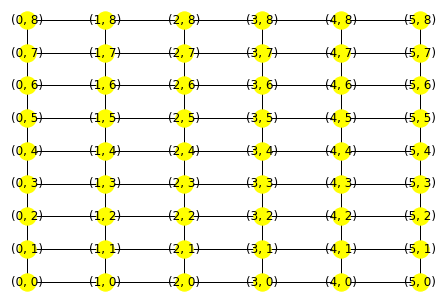

In [ ]:
#| include: false
#m, n = 3, 2
m, n = 6, 9
G0 = nx.grid_2d_graph(m,n)
#nx.draw(G, pos=)
pos ={(i,j):(i,j) for (i,j) in G0.nodes()}
#hidenx.draw(G0, pos=pos, with_labels=True,  node_color="yellow")

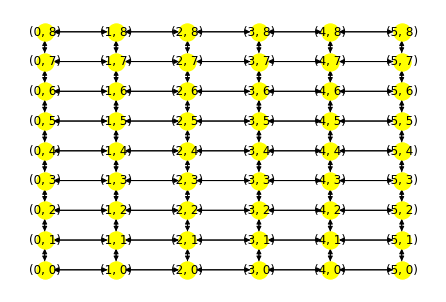

In [ ]:
#| include: false
G = nx.DiGraph() #有向グラフ：一方通行の場合には，必要な枝だけ追加する．
direction = [(1,0),(-1,0),(0,1),(0,-1)]
nodes = set(G0.nodes())
for (i,j) in G0.nodes():
    for (r,l) in direction:
        if (i+r,j+l) in nodes:
            G.add_edge((i,j),(i+r,j+l), weight=1)
#一方通行と点の削除            
#G.remove_edge((2,0),(2,1))
#G.remove_edge((2,1),(1,1))
nx.draw(G, pos=pos, with_labels=True,  node_color="yellow")

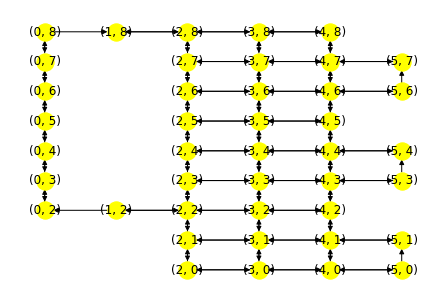

In [ ]:
#| include: false
G.remove_nodes_from([(0,0), (1,0), (0,1),(1,1), (1,3), (1,4),(1,5),(1,6),(1,7),(5,2),(5,5),(5,8)])
G.remove_edge((0,2),(1,2))
G.remove_edge((1,8),(0,8))
G.remove_edge((5,1),(5,0))
G.remove_edge((5,4),(5,3))
G.remove_edge((5,7),(5,6))
nx.draw(G, pos=pos, with_labels=True,  node_color="yellow")

In [ ]:
#| include: false
#ODの定義
#K = [ ((0,0), (2,1)), ((1,0),(2,1)) ]
#K = [ ((0,0), (2,1)), ((1,0),(2,1)), ((2,1),(1,0))   ]
K =[ ((5,1),(0,7)), ((5,4),(0,7)), ((5,7),(0,7)), ((0,7),(5,0)),((0,7),(5,3)),((0,7),(5,6)) ]
k = 3
#OD間の第k最短路の計算
all_paths = [] 
paths = {}
for (o,d) in K:
    cost_list, pathlist = k_th_sp(G, o, d, k)
    paths[o, d] = pathlist
    all_paths.extend(pathlist)
# Dictionary that maps a path (tuple) to the path index
path_id ={}
for i, p in enumerate(all_paths):
    path_id[p] = i

In [ ]:
#| include: false
#方向替えを考慮したパスの移動時間の計算（実際の時間を入力する）：ここでは１マス１秒，方向替えでさらに２秒で計算と仮定
cost = { } 
for p in all_paths:
    pid = path_id[p]
    u = p[0]
    v = p[1]
    delta = np.array(v)-np.array(u) #点の座標の差をとる
    total_penalty = 0 
    for w in p[2:]:
        delta_next = np.array(w)-np.array(v)
        direction = delta_next-delta #移動方向の差
        turn_penalty = np.abs(direction[0])+ np.abs(direction[1]) #方向替えのとき2
        total_penalty += 1+turn_penalty
        u = v
        v = w
        delta = delta_next
    cost[pid] = int(total_penalty)

In [ ]:
#| include: false
#パス間の干渉を計算
inter = { }
for i, (o,d) in enumerate(K):
    for j, (o2,d2) in enumerate(K):
        if i < j:
            for p in paths[o,d]:
                for q in paths[o2,d2]:
                    intersect = len(set(p[1:-1]) & set(q[1:-1])) #パス集合（始点と終点を除く）の共通部分の数
                    if intersect >0:
                        inter[path_id[p],path_id[q]] = intersect

#hide
## 混合整数計画問題の定式化

集合:

- $G=(N,A)$: 有向グラフ:；点集合はターミナルの集合，枝集合は移動可能な点対の集合． 

- $K$: 発ターミナル・着ターミナルの組（これを品種と呼ぶ）の集合． 

- $P_k$: 品種 $k \in K$ に対するパスの集合． すべてのパスの集合を $P$ とする．


パラメータ: 

- $o_k, d_k$: 品種 $k$ の発ターミナルと着ターミナル 
- $C_{p}$: パス $p$ の移動費用 
- $c_{pq}$: パス $p,q$ の干渉費用

変数:

- $x_{p}$: パス $p$ が使われるとき $1$，それ以外のとき $0$
- $y_{pq}$: パス $p,q$ が干渉するとき1，それ以外のとき $0$ 


定式化:

$$
\begin{array}{l l l } 
minimize  &  \sum_{p,q} c_{pq}  y_{pq} + \sum_{k \in K} \sum_{p \in P_k} C_{p} x_{p} &  \\
s.t.      & \sum_{p \in P_k} x_{p} = 1   &  \forall k \in K  \\
          &  x_{p} + x_{q} \leq 1 + y_{pq} &  \forall p,q   \\
\end{array}
$$


In [ ]:
#| include: false
# model = Model()
# x, y = {}, {}
# for (i,j) in inter:
#     y[i,j]= model.addVar(name="y[{0},{1}]".format(i,j), vtype="B") 
# for p, i in path_id.items():
#     x[i]= model.addVar(name="x[{0}]".format(i),vtype="B")
# total_conflict_cost = model.addVar(name="total_conflict_cost", vtype="C")
# total_move_cost =  model.addVar(name="total_move_cost", vtype="C")


# #目的関数
# model.setObjective( total_conflict_cost+ total_move_cost, GRB.MINIMIZE )
# model.addConstr( total_move_cost == quicksum( cost[ path_id[p]] *x[ path_id[p] ] for (o,d) in K for p in paths[o,d] ) ) 
# model.addConstr( total_conflict_cost == quicksum(inter[i,j]*y[i,j] for (i,j) in y ) )

# for (o,d) in K:
#     model.addConstr( quicksum( x[ path_id[p] ] for p in paths[o,d] ) == 1 )
# for (i,j) in inter:
#     model.addConstr( x[i]+x[j] <= 1 + y[i,j]   )

In [ ]:
#| include: false
#model.optimize()

In [ ]:
#| include: false
# path_list =[]
# for (o,d) in K:
#     for p in paths[o,d]:
#          if x[path_id[p]].X > 0.01:
#             print(o,d,":",p)
# for (i,j) in inter:
#     if y[i,j].X > 0.01:
#         print(i,j, inter[i,j]*y[i,j].X)
        
# print("総費用",model.ObjVal, "干渉費用", total_conflict_cost.X, "移動費用", total_move_cost.X)

In [ ]:
#| include: false
#可視化
# x_coord, y_coord =[], []
# for (i,j) in G:
#     x_coord.append(i)
#     y_coord.append(j)
# data = [
#     go.Scatter(
#         x = x_coord,
#         y = y_coord, 
#         mode='markers',
#         marker=dict(
#             size=20, color="blue", opacity=0.9
#         ),
#         name="nodes"
#     ),
# ]

# for (o,d) in K:
#     edge_trace_x, edge_trace_y = [], []
#     for p in paths[o,d]:
#         if x[path_id[p]].X > 0.1:
#             v = p[0]
#             for w in p[1:]:
#                 edge_trace_y += [pos[v][1], pos[w][1], None]
#                 edge_trace_x += [pos[v][0], pos[w][0], None]
#                 v = w
#     data.append(
#             go.Scatter(
#                 x = edge_trace_x,
#                 y = edge_trace_y,
#                 line=dict(width=2,color="red"),
#                 hoverinfo='none',
#                 mode='lines',
#                 name= f"Path between {o} and {d}"
#             )
#         )

# layout = go.Layout(
#     autosize=True,
#     hovermode='closest'
# )
# fig = go.Figure(data=data, layout=layout)
# plotly.offline.plot(fig);

#hide
## 制約最適化での定式化

変数：
- $X[k]$: 品種 $k$ に対するパスの集合を領域とした変数


値変数:

- $x_{kp}$: 品種 $k$ に対してパス $p$ が使われるとき $1$，それ以外のとき $0$ 

定式化:

$$
\begin{array}{l l l } 
minimize  &  \sum_{k,k'} \sum_{p,q} c_{pq} x_{kp} x_{k'q} + \sum_{k \in K} \sum_{p \in P_k} C_{p} x_{kp} &  
\end{array}
$$


In [ ]:
#| include: false
# import scmopt2.scop as scop

# model = scop.Model()
# X = {}
# for (o,d) in K:
#     domain =[]
#     for p in paths[o,d]:
#         domain.append( path_id[p] )
#     X[o,d] = model.addVariable(name=f"X[{o}{d}]", domain= domain)
    
# con1 = scop.Linear('path_cost',weight=1,rhs=0,direction='<=')
# for (o,d) in K:
#     for p in paths[o,d]:
#         con1.addTerms(cost[path_id[p]],X[o,d],path_id[p])
# model.addConstraint( con1 ) 

# con2 = scop.Quadratic('conflict_cost',weight=1,rhs=0,direction='<=')
# for i, (o,d) in enumerate(K):
#     for j, (o2,d2) in enumerate(K):
#         if i < j:
#             for p in paths[o,d]:
#                 for q in paths[o2,d2]:
#                     pid = path_id[p]
#                     qid = path_id[q]
#                     if (pid,qid) in inter:
#                         con2.addTerms(inter[pid,qid],X[o,d],pid,X[o2,d2],qid)
# model.addConstraint( con2 ) 

# print(model)

In [ ]:
#| include: false
# model.Params.TimeLimit=3
# sol,violated=model.optimize()

In [ ]:
#| include: false
# x_coord, y_coord =[], []
# for (i,j) in G:
#     x_coord.append(i)
#     y_coord.append(j)
# data = [
#     go.Scatter(
#         x = x_coord,
#         y = y_coord, 
#         mode='markers',
#         marker=dict(
#             size=20, color="blue", opacity=0.9
#         ),
#         name="nodes"
#     ),
# ]

# for o,d in X:
#     p = all_paths[ int(X[o,d].value) ]
#     edge_trace_x, edge_trace_y = [], []
#     v = p[0]
#     for w in p[1:]:
#         edge_trace_y += [pos[v][1], pos[w][1], None]
#         edge_trace_x += [pos[v][0], pos[w][0], None]
#         v = w
#     data.append(
#             go.Scatter(
#                 x = edge_trace_x,
#                 y = edge_trace_y,
#                 line=dict(width=2,color="red"),
#                 hoverinfo='none',
#                 mode='lines',
#                 name= f"Path between {o} and {d}"
#             )
#         )

# layout = go.Layout(
#     autosize=True,
#     hovermode='closest'
# )
# fig = go.Figure(data=data, layout=layout)
# plotly.offline.plot(fig);